In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..") # Adds higher directory to python modules path.
import h5py
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA
import torch
import time
import warnings
warnings.filterwarnings("ignore")
from locanmf import LocaNMF
import postprocess
import pandas as pd

In [2]:
import os
## [OPTIONAL] if cuda support, uncomment following lines
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
# device='cuda'

# else, if on cpu
device='cpu'

# User-defined Parameters

In [3]:
##################################################################################################################
## PARAMETERS THAT YOU SHOULD CHANGE
##################################################################################################################
# Path to data and atlas
mouse_name = 'IA1'
session_name = 'Feb3'
data_folder ='./data/'+mouse_name+'/'+session_name+'/'
# spatial_data_filename = "IA1_spatial.npy" #
spatial_data_filename =mouse_name+'pm_'+session_name+'_30Hz_code_04_trial_ROItimeCourses_30sec_pca_0.95_spatial.npy'
# temporal_data_filename = "IA1_temporal.npy" # 
temporal_data_filename = mouse_name+'pm_'+session_name+'_30Hz_code_04_trial_ROItimeCourses_30sec_pca_0.95.npy'
# atlas_filename = "maskwarp_1.npy" # contains 'atlas'
random_spatial_data_filename =mouse_name+'pm_'+session_name+'_30Hz_code_04_random_ROItimeCourses_30sec_pca_0.95_spatial.npy'
# temporal_data_filename = "IA1_temporal.npy" # 
random_temporal_data_filename = mouse_name+'pm_'+session_name+'_30Hz_code_04_random_ROItimeCourses_30sec_pca_0.95.npy'
save_folder='./IJ1_Mar3/'
save_name='IJ1_Mar3_'

# atlas_filename = "atlas_split.npy"
atlas_filename='atlas_fixed_pixel.npy'

# maxrank = how many max components per brain region. Set maxrank to around 4 for regular dataset.
maxrank = 1
  
# min_pixels = minimum number of pixels in Allen map for it to be considered a brain region
# default min_pixels = 100
min_pixels = 200

# loc_thresh = Localization threshold, i.e. percentage of area restricted to be inside the 'Allen boundary'
# default loc_thresh = 80
loc_thresh =90

# r2_thresh = Fraction of variance in the data to capture with LocaNMF
# default r2_thresh = 0.99
r2_thresh = 0.96

# Do you want nonnegative temporal components? The data itself should also be nonnegative in this case.
# default nonnegative_temporal = False
nonnegative_temporal = False 

##################################################################################################################
## PARAMETERS THAT YOU SHOULD PROBABLY NOT CHANGE (unless you know what you're doing)
##################################################################################################################
# maxiter_hals = Number of iterations in innermost loop (HALS). Keeping this low provides a sort of regularization.
# default maxiter_hals = 20
maxiter_hals = 20

# maxiter_lambda = Number of iterations for the lambda loop. Keep this high for finding a good solution.
# default maxiter_lambda = 100
maxiter_lambda = 100

# lambda_step = Amount to multiply lambda after every lambda iteration. 
# lambda_init = initial value of lambda. Keep this low. default lambda_init = 0.000001
# lambda_{i+1}=lambda_i*lambda_step. lambda_0=lambda_init. default lambda_step = 1.35
lambda_step = 2.25
lambda_init = 1e-1


In [4]:
# spatial_data_filename.shape
a=np.load(data_folder+spatial_data_filename)
print(a.shape)
b=np.load(data_folder+temporal_data_filename)
print(b.shape)

(5, 16384)
(62, 5, 1801)


# Load & Format Data

In [5]:
spatial = np.load(data_folder+spatial_data_filename)
# spatial_random = np.load(data_folder+random_spatial_data_filename)
# spatial=np.concatenate(spatial_trial,spatial_random,axis=0)
spatial = np.transpose(spatial,[1,0])
denoised_spatial_name = np.reshape(spatial,[128,128,-1])

temporal_trial = np.load(data_folder+temporal_data_filename)
temporal_random = np.load(data_folder+random_temporal_data_filename)
temporal=np.concatenate((temporal_trial,temporal_random),axis=0)
temporal = np.transpose(temporal,[1,0,2])
# denoised_temporal_name = np.reshape(temporal,[-1,42*601])
denoised_temporal_name = np.reshape(temporal,[-1,temporal.shape[1]*temporal.shape[2]])
print('loaded data\n',flush=True)

atlas = np.load('./'+atlas_filename)#['atlas'].astype(float)
#areanames = sio.loadmat(data_folder+atlas_filename)['areanames']

loaded data



In [6]:
print(temporal_trial.shape)
print(temporal_random.shape)

(62, 5, 1801)
(58, 5, 1801)


In [7]:
rois=np.load('./rois_50.npz')
rois_name=rois['names']
rois_name
rois_ids=rois['ids']

In [8]:
atlas.shape

(128, 128)

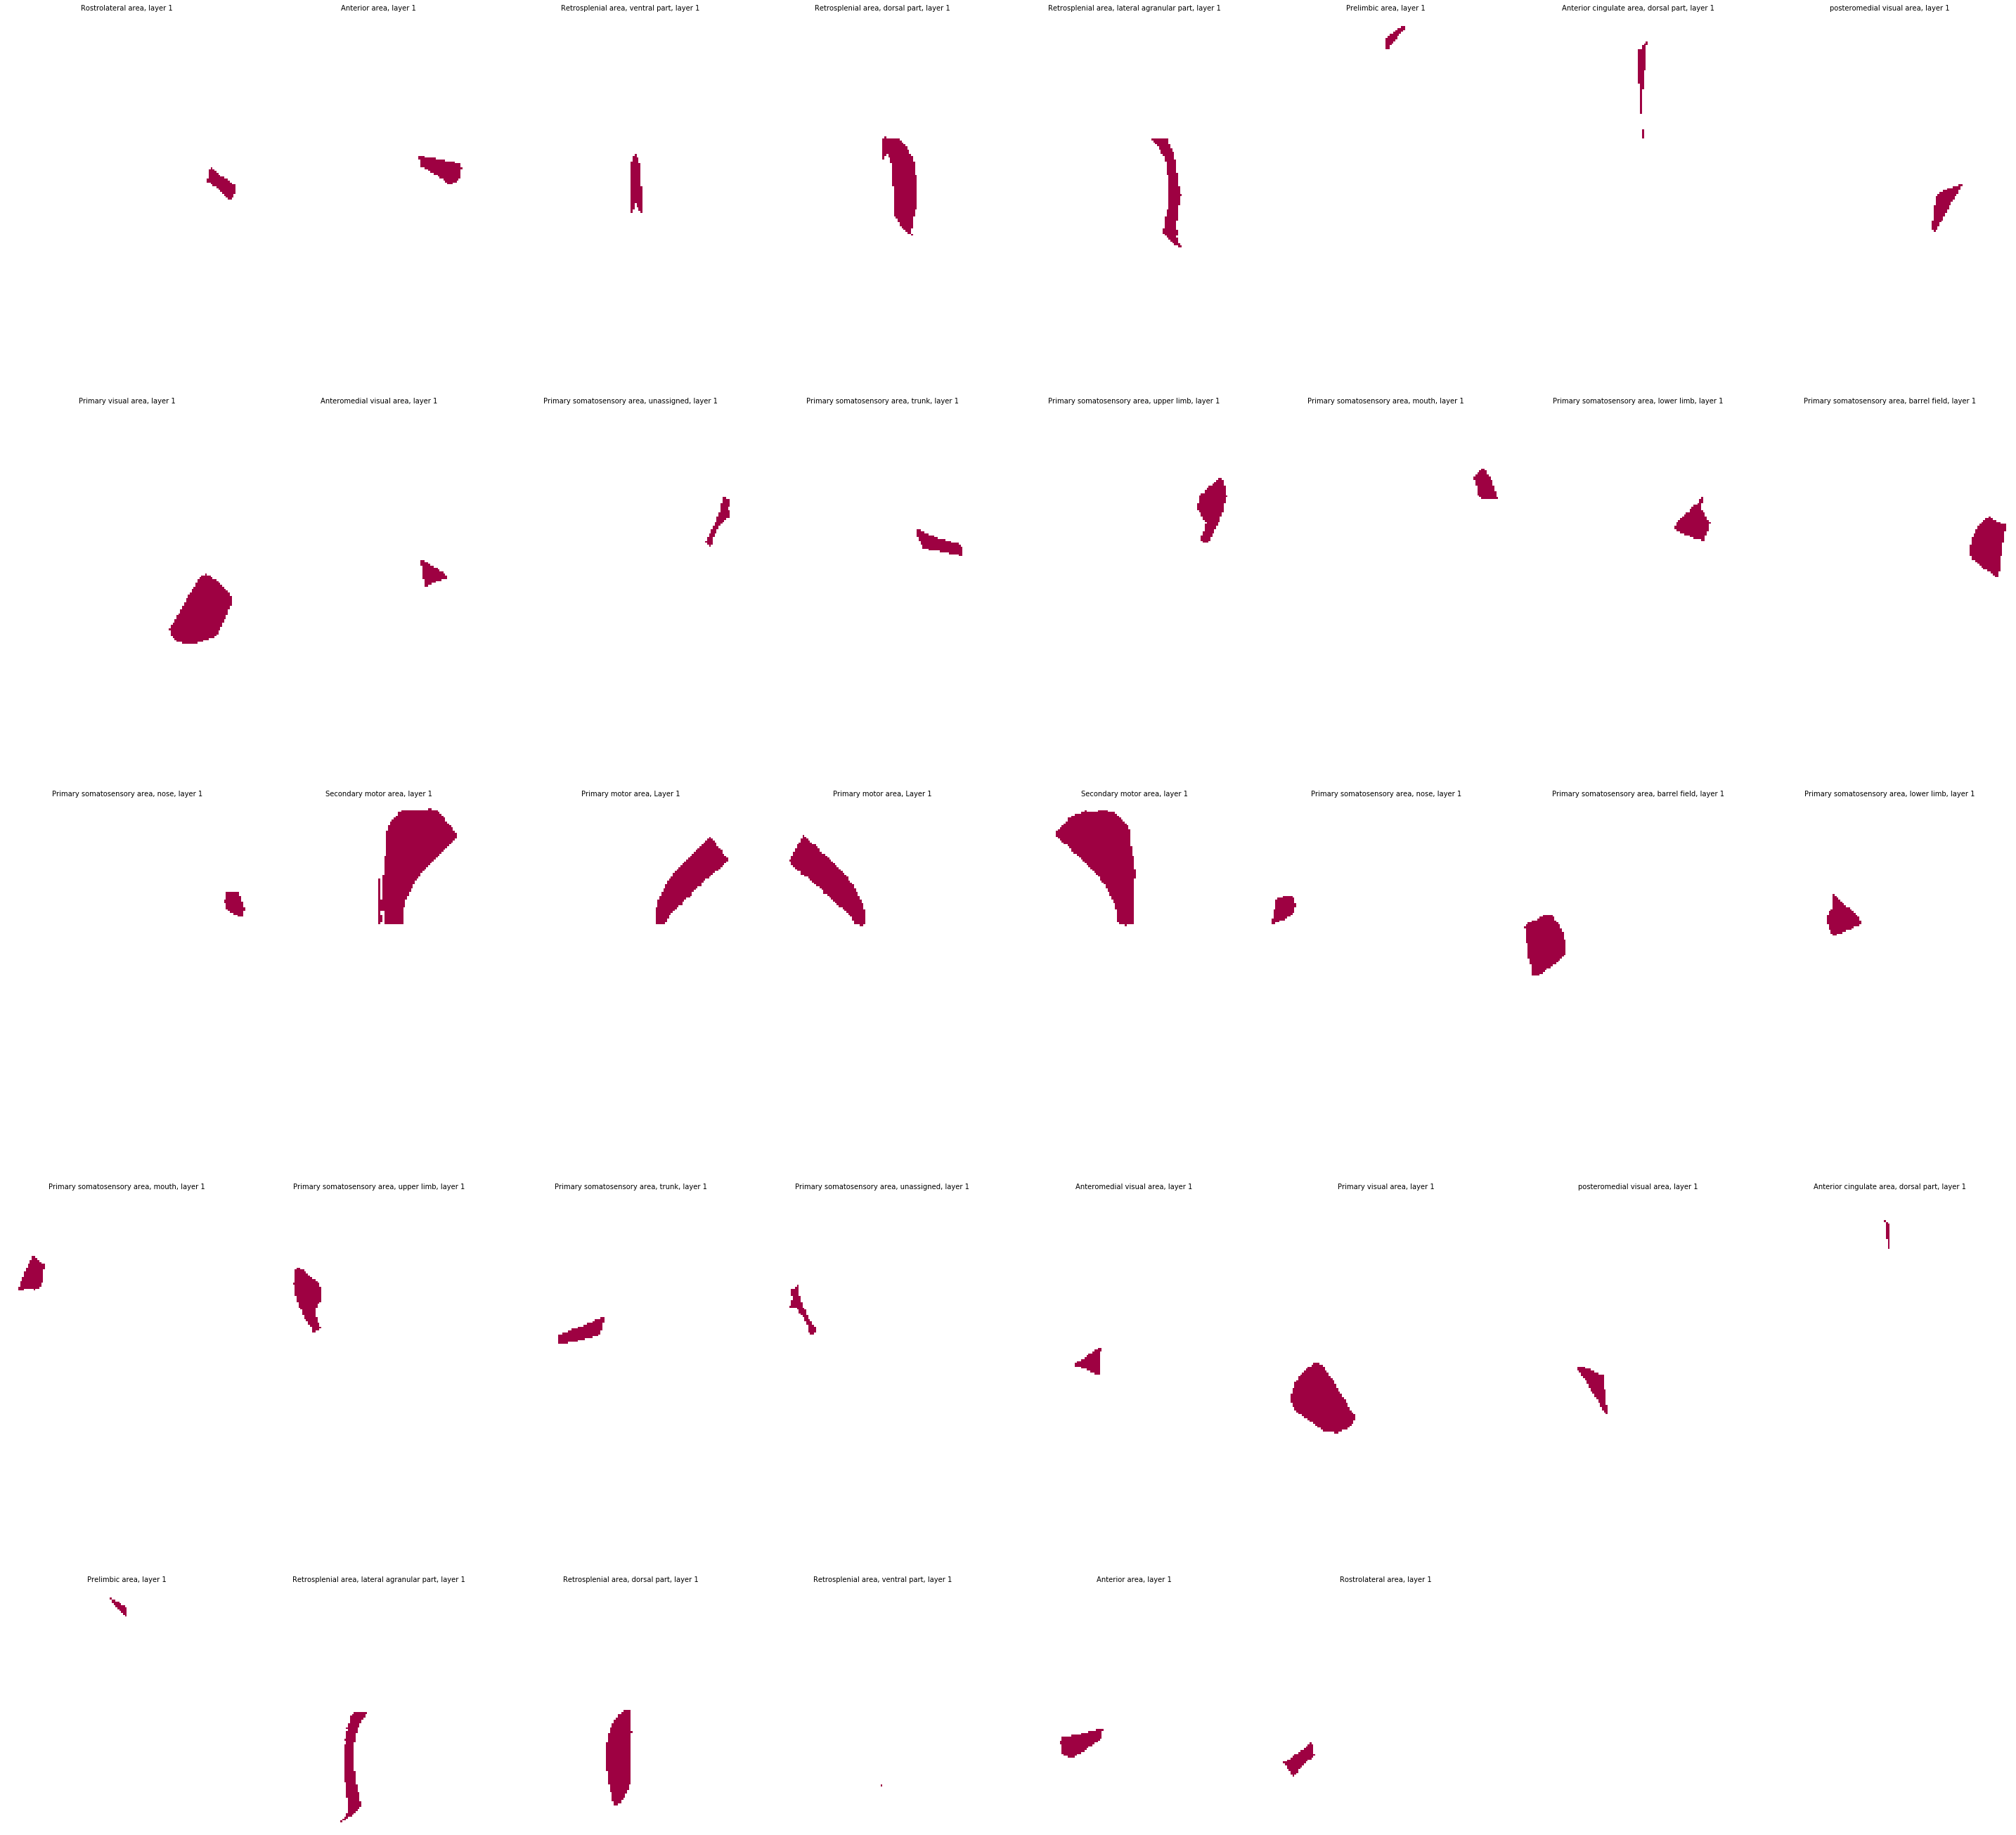

In [9]:
atlas_split=atlas
itt=0
fig=plt.figure(figsize=(40,40))
b_=[]
for it in np.unique(atlas_split):
    if np.abs(it) !=0:
        plotmap=np.zeros((atlas_split.shape)); plotmap.fill(np.nan); plotmap[atlas_split==it]=atlas_split[atlas_split==it]
        plt.subplot(5,8,itt+1)
        plt.imshow(plotmap,cmap='Spectral'); plt.axis('off'); 
        plt.title(rois_name[np.where(rois_ids==np.abs(it))][0],fontsize=10); 
        b_.append(plotmap)
        #     plt.show()
        itt=itt+1
plt.tight_layout(h_pad=0.5,w_pad=0.5)


(5, 216120)
(128, 128, 5)
(128, 128)


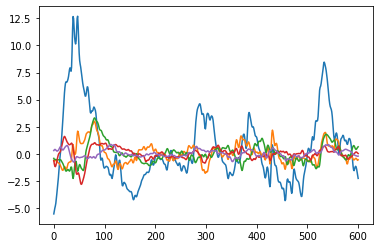

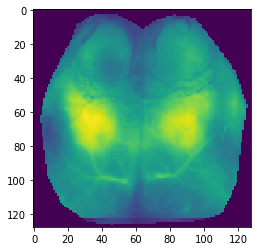

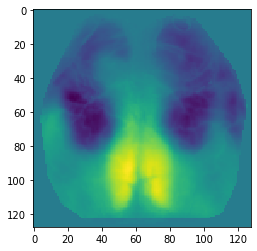

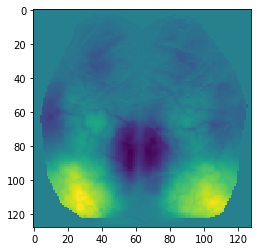

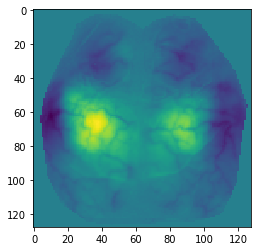

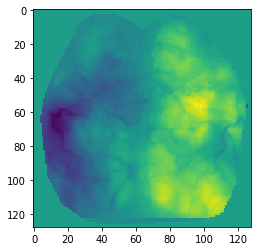

In [10]:
print(denoised_temporal_name.shape)
print(denoised_spatial_name.shape)
print(atlas.shape)
plt.plot(denoised_temporal_name[:,:601].T); plt.show()

for i in np.arange(denoised_spatial_name.shape[2]):
    plt.imshow(denoised_spatial_name[:,:,i]); 
    plt.show()

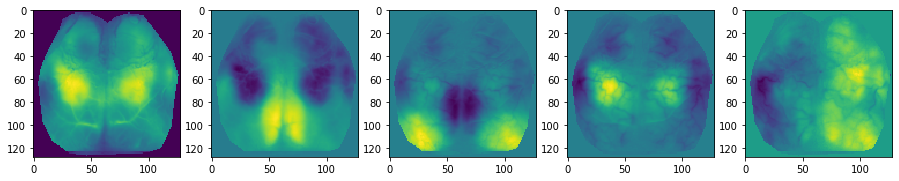

In [11]:
fig=plt.figure(figsize=(20,20))
for i in np.arange(denoised_spatial_name.shape[2]):
    plt.subplot(3,8,i+1)
    plt.imshow(denoised_spatial_name[:,:,i]);
plt.tight_layout(h_pad=0.5,w_pad=0.5)
plt.show()

In [12]:
# Get data in the correct format
V=denoised_temporal_name
U=denoised_spatial_name
# if dotranspose:
#     V=V.T
#     U=U.transpose((2,1,0))
# if brainmask_name not in arrays:
brainmask = np.ones(U.shape[:2],dtype=bool)
# else:
#     brainmask=arrays[brainmask_name]==1
#     # if h5py file
#     if dotranspose:
#         brainmask=brainmask.T
# plt.imshow(brainmask); plt.show()
# Load true areas if simulated data
simulation=0
# if 'trueareas' in arrays:
#     print('simulation!')
#     trueareas=arrays['trueareas'].flatten()
#     simulation=1

# Include nan values of U in brainmask, and put those values to 0 in U 
brainmask[np.isnan(np.sum(U,axis=2))]=False
U[np.isnan(U)]=0
# Preprocess V: flatten and remove nans
dimsV=V.shape
keepinds=np.nonzero(np.sum(np.isfinite(V),axis=0))[0]
V=V[:,keepinds]

# del arrays

In [13]:
U.shape

(128, 128, 5)

Rank of video : 5
Number of timepoints : 216120


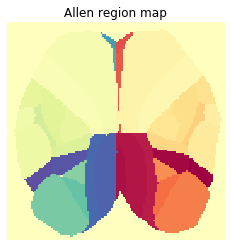

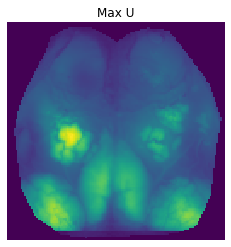

In [14]:
# Check that data has the correct shapes. V [K_d x T], U [X x Y x K_d], brainmask [X x Y]
if V.shape[0]!=U.shape[-1]: print('Wrong dimensions of U and V!')
print("Rank of video : %d" % V.shape[0]); print("Number of timepoints : %d" % V.shape[1]); 

# Plot the maximum of U
plotmap=np.zeros((atlas.shape)); plotmap.fill(np.nan); plotmap[brainmask]=atlas[brainmask]
plt.imshow(plotmap,cmap='Spectral'); plt.axis('off'); plt.title('Allen region map'); plt.show(); 
plt.imshow(np.max(U,axis=2)); plt.axis('off'); plt.title('Max U'); plt.show()


In [15]:
# Perform the LQ decomposition. Time everything.
t0_global = time.time()
t0 = time.time()
if nonnegative_temporal:
    r = V.T
else:
    q, r = np.linalg.qr(V.T)
time_ests={'qr_decomp':time.time() - t0}

# Initialize LocaNMF

In [16]:
# Put in data structure for LocaNMF
video_mats = (np.copy(U[brainmask]), r.T)
rank_range = (1, maxrank, 1)
del U


In [17]:
# region_mats[0] = [unique regions x pixels] the mask of each region
# region_mats[1] = [unique regions x pixels] the distance penalty of each region
# region_mats[2] = [unique regions] area code
region_mats = LocaNMF.extract_region_metadata(brainmask, atlas, min_size=min_pixels)

region_metadata = LocaNMF.RegionMetadata(region_mats[0].shape[0],
                                           region_mats[0].shape[1:],
                                           device=device)

region_metadata.set(torch.from_numpy(region_mats[0].astype(np.uint8)),
                    torch.from_numpy(region_mats[1]),
                    torch.from_numpy(region_mats[2].astype(np.int64)))


In [18]:
region_mats[1].shape


(16, 16384)

In [19]:
region_mats[2]

array([-255., -249., -150.,  -57.,  -43.,  -36.,  -21.,  -15.,   15.,
         21.,   36.,   43.,   57.,  150.,  249.,  255.])

In [20]:
region_mats[2].shape

(16,)

In [21]:
rois=np.load('./rois_50.npz')
rois_name=rois['names']
rois_name
rois_ids=rois['ids']

In [22]:
# Do SVD as initialization
if device=='cuda': torch.cuda.synchronize()
print('v SVD Initialization')
t0 = time.time()
region_videos = LocaNMF.factor_region_videos(video_mats,
                                               region_mats[0],
                                               rank_range[1],
                                               device=device)
if device=='cuda': torch.cuda.synchronize()
print("\'-total : %f" % (time.time() - t0))
time_ests['svd_init'] = time.time() - t0

v SVD Initialization
'-total : 0.029570


In [23]:
low_rank_video = LocaNMF.LowRankVideo(
    (int(np.sum(brainmask)),) + video_mats[1].shape, device=device
)
low_rank_video.set(torch.from_numpy(video_mats[0].T),
                   torch.from_numpy(video_mats[1]))

# LocaNMF

In [24]:
##########################################################
############### Please replace this part #################
##########################################################
if device=='cuda': torch.cuda.synchronize()
print('v Rank Line Search')
t0 = time.time()
locanmf_comps,loc_save,save_lam,save_scale,save_per,save_spa,save_scratch = LocaNMF.rank_linesearch(low_rank_video,
                                            region_metadata,
                                            region_videos,
                                            maxiter_rank=maxrank,
                                            maxiter_lambda=maxiter_lambda, 
                                            maxiter_hals=maxiter_hals,
                                            lambda_step=lambda_step,
                                            lambda_init=lambda_init, 
                                            loc_thresh=loc_thresh,
                                            r2_thresh=r2_thresh,
                                            rank_range=rank_range,
#                                             nnt=nonnegative_temporal,
                                            verbose=[True, False, False],
                                            sample_prop=(1,1),
                                            device=device
                                         )
if device=='cuda': torch.cuda.synchronize()
print("\'-total : %f" % (time.time() - t0))
time_ests['rank_linesearch'] = time.time() - t0
##########################################################
############### Please replace this part #################
##########################################################

v Rank Line Search
|--v Rank Line Search Iteration 0
|  |--v Initialization
|  |  '-total : 0.004995 seconds
|  |--v Lambda Line Search
|  |  '- 14 iterations took 1.44368 seconds
|  |--> R2 Evaluation took 7.86781e-06 seconds
|  '-total : 1.44911 seconds
'-total : 1.544749


In [25]:
ratio=torch.norm(loc_save.spatial.scratch,p=2,dim=-1)/torch.norm(loc_save.spatial.data,p=2,dim=-1)
per=100*(ratio**2)
per# how much of the spatial component is inside the ROI

tensor([91.3049, 93.9345, 95.3744, 96.8599, 95.1405, 97.3378, 98.4988, 90.3381,
        94.1922, 90.5645, 94.4945, 93.4863, 90.4939, 93.2921, 95.0057, 92.8094])

In [26]:
print("Number of components : %d" % len(locanmf_comps))


Number of components : 16


In [27]:
mov = torch.matmul(low_rank_video.spatial.data.t(),low_rank_video.temporal.data)
var = torch.mean(torch.var(mov, dim=1, unbiased=False))  # TODO: Precompute this
var_ests=np.zeros((len(locanmf_comps)))
for i in np.arange(len(locanmf_comps)):
    mov = torch.matmul(torch.index_select(locanmf_comps.spatial.data,0,torch.tensor([i])).t(),
                       torch.index_select(locanmf_comps.temporal.data,0,torch.tensor([i])))
    var_i = torch.mean(torch.var(mov, dim=1, unbiased=False))  
    
    # mean(var(dataest))/mean(var(data))
    var_ests[i] = var_i.item() / var.item()

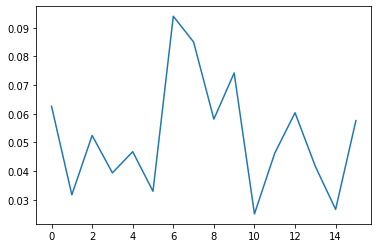

[10 14  1  5  3 13 11  4  2 15  8 12  0  9  7  6]
[0.02510386 0.02667727 0.0317539  0.03299177 0.03941079 0.04169194
 0.04628075 0.04679774 0.05245534 0.05764441 0.05815154 0.060368
 0.06260973 0.07424382 0.08503722 0.09401101]


In [28]:
plt.plot(var_ests); plt.show()
print(np.argsort(var_ests))
print(var_ests[np.argsort(var_ests)])


In [29]:
# Evaluate R^2
_,r2_fit=LocaNMF.evaluate_fit_to_region(low_rank_video,
                                           locanmf_comps,
                                           region_metadata.support.data.sum(0),
                                           sample_prop=(1, 1))
print("R^2 fit on all data : %f" % r2_fit)

time_ests['global_time'] = time.time()-t0_global

R^2 fit on all data : 0.959870


In [30]:
C = np.matmul(q,locanmf_comps.temporal.data.cpu().numpy().T).T
qc, rc = np.linalg.qr(C.T)

0.8352290758814735


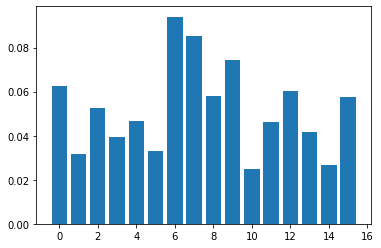

In [31]:
print(np.sum(var_ests))
plt.bar(np.arange(len(locanmf_comps)),var_ests); plt.show()

In [32]:
var_est=np.zeros((len(locanmf_comps)))
for i in np.arange(len(locanmf_comps)):
    var_est[i]=np.var(C[i,:])/np.var(C)
    

In [33]:
locanmf_comps.regions.data

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

# Reformat spatial and temporal matrices, and save

In [34]:
# Assigning regions to components
region_ranks = []; region_idx = []

for rdx in torch.unique(locanmf_comps.regions.data, sorted=True):
    region_ranks.append(torch.sum(rdx == locanmf_comps.regions.data).item())
    region_idx.append(rdx.item())

areas=region_metadata.labels.data[locanmf_comps.regions.data].cpu().numpy()

In [35]:
# Get LocaNMF spatial and temporal components
A=locanmf_comps.spatial.data.cpu().numpy().T
A_reshape=np.zeros((brainmask.shape[0],brainmask.shape[1],A.shape[1])); A_reshape.fill(np.nan)
A_reshape[brainmask,:]=A

if nonnegative_temporal:
    C=locanmf_comps.temporal.data.cpu().numpy()
else:
    C=np.matmul(q,locanmf_comps.temporal.data.cpu().numpy().T).T
    
# Add back removed columns from C as nans
C_reshape=np.full((C.shape[0],dimsV[1]),np.nan)
C_reshape[:,keepinds]=C
C_reshape=np.reshape(C_reshape,[C.shape[0],dimsV[1]])

# Get lambdas
lambdas=np.squeeze(locanmf_comps.lambdas.data.cpu().numpy())

In [36]:
A_reshape.shape

(128, 128, 16)

In [37]:
c_p=C_reshape.reshape(A_reshape.shape[2],int(C_reshape.shape[1]/1801),1801)

In [38]:
c_plot=c_p.transpose((1,0,2))
c_plot.shape

(120, 16, 1801)

In [39]:
# save LocaNMF data
# np.save(save_folder+save_name+'locanmf_trial.npy',c_plot[:int(c_plot.shape[0]/2),:,:])
# np.save(save_folder+save_name+'locanmf_random.npy',c_plot[int(c_plot.shape[0]/2):,:,:])

In [40]:
t_plot=temporal.transpose((1,0,2))

In [41]:
temporal.shape

(5, 120, 1801)

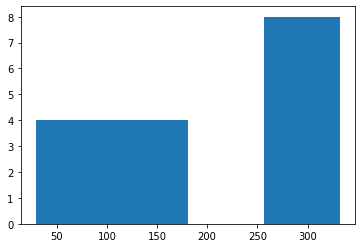

tensor([147.7892, 332.5257, 147.7892, 332.5257, 332.5257, 332.5257,  65.6841,
         65.6841,  65.6841,  29.1929, 332.5257, 332.5257, 332.5257, 147.7892,
        332.5257, 147.7892])


In [42]:
# Plot the distribution of lambdas. 
# If lots of values close to the minimum, decrease lambda_init.
# If lots of values close to the maximum, increase maxiter_lambda or lambda_step.
plt.hist(locanmf_comps.lambdas.data.cpu(), bins=torch.unique(locanmf_comps.lambdas.data).shape[0])
plt.show()
print(locanmf_comps.lambdas.data.cpu())

In [43]:
region_name=region_mats[2]
region_name.shape

(16,)

In [44]:
region_name

array([-255., -249., -150.,  -57.,  -43.,  -36.,  -21.,  -15.,   15.,
         21.,   36.,   43.,   57.,  150.,  249.,  255.])

In [45]:
def parse_areanames_new(region_name,rois_name):
    areainds=[]; areanames=[];
    for i,area in enumerate(region_name):
        areainds.append(area)
        areanames.append(rois_name[np.where(rois_ids==np.abs(area))][0])
    sortvec=np.argsort(np.abs(areainds))
    areanames=[areanames[i] for i in sortvec]
    areainds=[areainds[i] for i in sortvec]
    return areainds,areanames


In [46]:
# Get area names for all components
areainds,areanames_all =parse_areanames_new(region_name,rois_name)
areanames_area=[]
for i,area in enumerate(areas):
    areanames_area.append(areanames_all[areainds.index(area)])
    

In [47]:
areas

array([-255, -249, -150,  -57,  -43,  -36,  -21,  -15,   15,   21,   36,
         43,   57,  150,  249,  255])

In [48]:
square_atlas=[]
for i in range(areas.shape[0]):
    square_atlas.append(np.sum(atlas==areas[i]))
np.shape(square_atlas)

(16,)

In [49]:
# Save results!
print("LocaNMF completed successfully in "+ str(time.time()-t0_global) + "\n")
print("Results saved in "+data_folder+'locanmf_decomp_loc'+str(loc_thresh)+'.mat')
sio.savemat(data_folder+'locanmf_decomp_loc'+str(loc_thresh)+'.mat',
            {'C':C_reshape,
             'A':A_reshape,
             'lambdas':lambdas,
             'areas':areas,
             'r2_fit':r2_fit,
             'time_ests':time_ests,
             'areanames':areanames_area
            })
torch.cuda.empty_cache()

LocaNMF completed successfully in 4.826783180236816

Results saved in ./data/IA1/Feb3/locanmf_decomp_loc90.mat


In [50]:
# fig=plt.figure(figsize=(10,8))
# for i in np.arange(denoised_spatial_name.shape[2]):
#     plt.subplot(2,5,i+1)
#     plt.imshow(denoised_spatial_name[:,:,i]); 
# plt.tight_layout(h_pad=0.5,w_pad=0.5)
# plt.show()

In [51]:
# calculate ROI data
roi_spatial=np.zeros((A_reshape.shape[2],denoised_spatial_name.shape[2]))
for i in range(denoised_spatial_name.shape[2]):
    for j in range(A_reshape.shape[2]):
        A_masking=np.zeros((A_reshape[:,:,j].shape))
        A_masking[A_reshape[:,:,j]!=0]=1
        A_multiply=A_masking*denoised_spatial_name[:,:,i]
        roi_spatial[j,i]=np.sum(A_multiply)/np.sum(A_masking)
        
roi_data=[]
for s in range(temporal_trial.shape[0]):
    roi_each=roi_spatial@temporal_trial[s]
    roi_data.append(roi_each)
roi_save_trial=np.array(roi_data)
roi_save_trial.shape

(62, 16, 1801)

In [52]:
roi_spatial=np.zeros((A_reshape.shape[2],denoised_spatial_name.shape[2]))
for i in range(denoised_spatial_name.shape[2]):
    for j in range(A_reshape.shape[2]):
        A_masking=np.zeros((A_reshape[:,:,j].shape))
        A_masking[A_reshape[:,:,j]!=0]=1
        A_multiply=A_masking*denoised_spatial_name[:,:,i]
        roi_spatial[j,i]=np.sum(A_multiply)/np.sum(A_masking)
        
roi_data=[]
for s in range(temporal_random.shape[0]):
    roi_each=roi_spatial@temporal_random[s]
    roi_data.append(roi_each)
roi_save_random=np.array(roi_data)
roi_save_random.shape

(58, 16, 1801)

In [53]:
# save ROI data
# np.save(save_folder+save_name+'trial.npy',roi_save_trial)
# np.save(save_folder+save_name+'random.npy',roi_save_random)

# Visualization of components

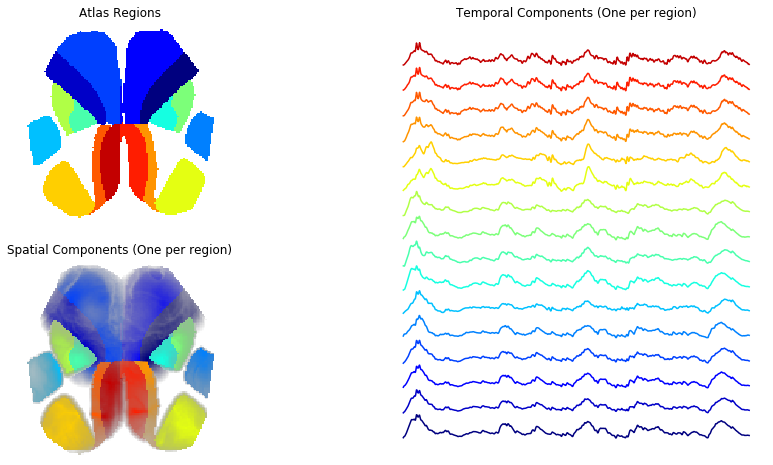

In [54]:
# Spatial and Temporal Components: Summary
atlascolor=np.zeros((atlas.shape[0],atlas.shape[1],4))
A_color=np.zeros((A_reshape.shape[0],A_reshape.shape[1],4))
cmap=plt.cm.get_cmap('jet')
colors=cmap(np.arange(len(areainds))/len(areainds))
for i,area_i in enumerate(areainds):
    if area_i not in areas:
        continue
    atlascolor[atlas==area_i,:]=colors[i,:]
    C_area=C[np.where(areas==area_i)[0],:]
    for j in np.arange(colors.shape[1]):
        A_color[:,:,j]=A_color[:,:,j]+colors[i,j]*A_reshape[:,:,np.where(areas==area_i)[0][0]]
fig=plt.figure(figsize=(15,8))
ax1=fig.add_subplot(2,2,1)
ax1.imshow(atlascolor)
ax1.set_title('Atlas Regions')
ax1.axis('off')
ax2=fig.add_subplot(2,2,3)
ax2.imshow(A_color)
ax2.set_title('Spatial Components (One per region)')
ax2.axis('off')
ax3=fig.add_subplot(1,2,2)
axvar=0
for i,area_i in enumerate(areainds):
    if area_i not in areas:
        continue
    C_area=C[np.where(areas==area_i)[0][0],:min(1000,C.shape[1])]
    ax3.plot(1.5*axvar+C_area/np.nanmax(np.abs(C_area)),color=colors[i,:])
    axvar+=1
ax3.set_title('Temporal Components (One per region)')
ax3.axis('off') 
plt.show()

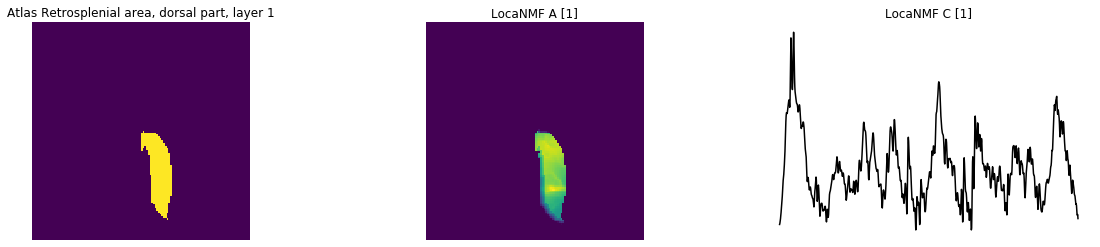

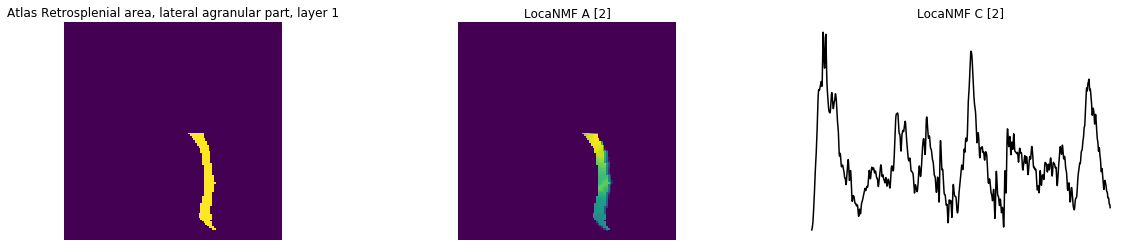

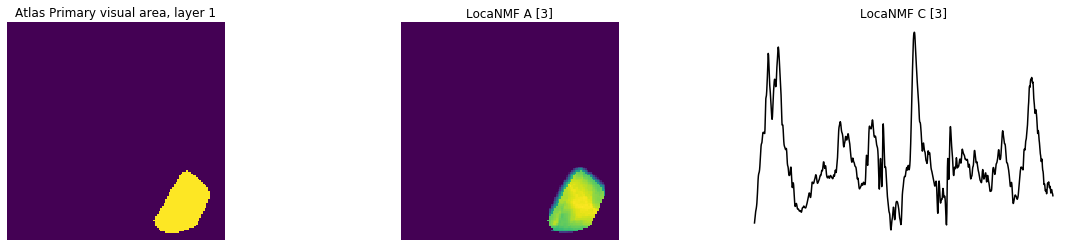

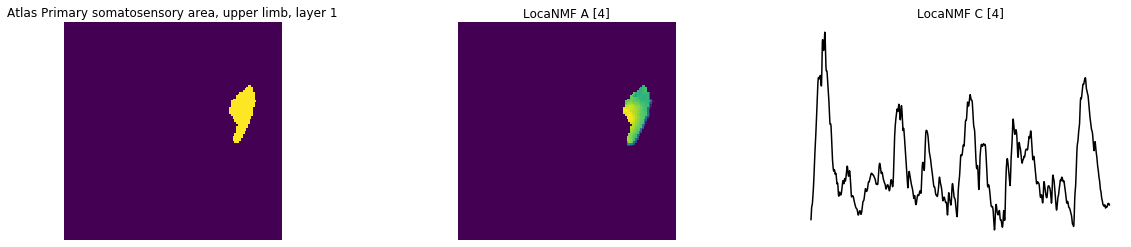

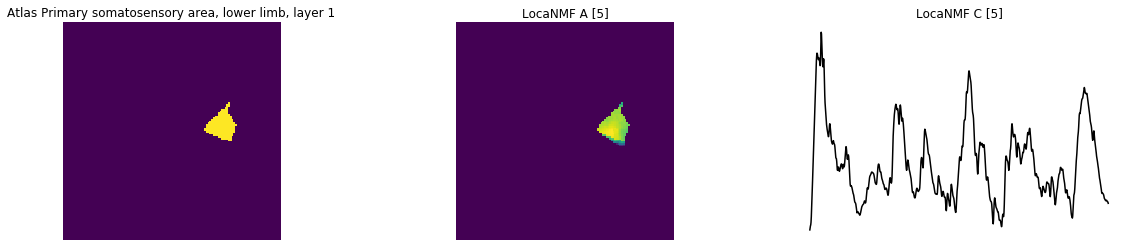

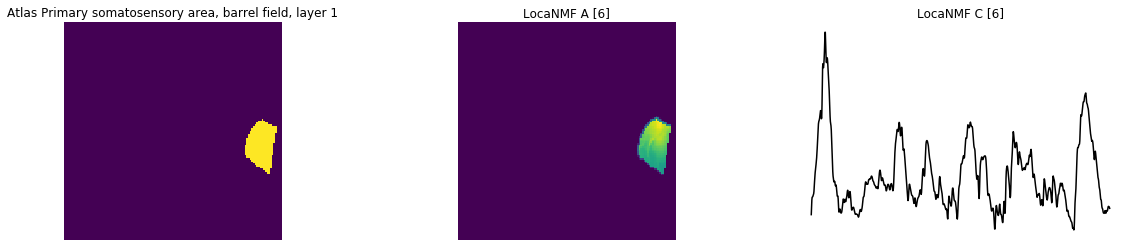

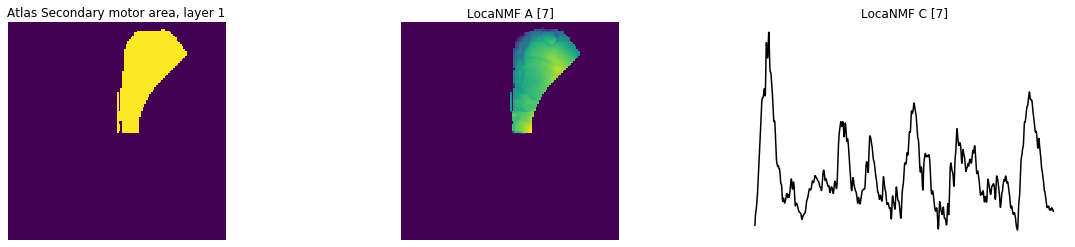

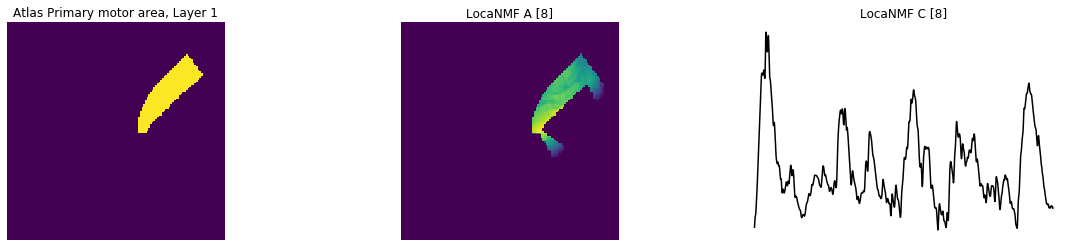

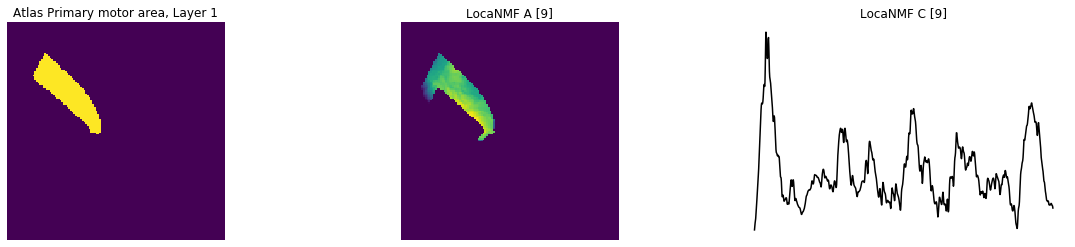

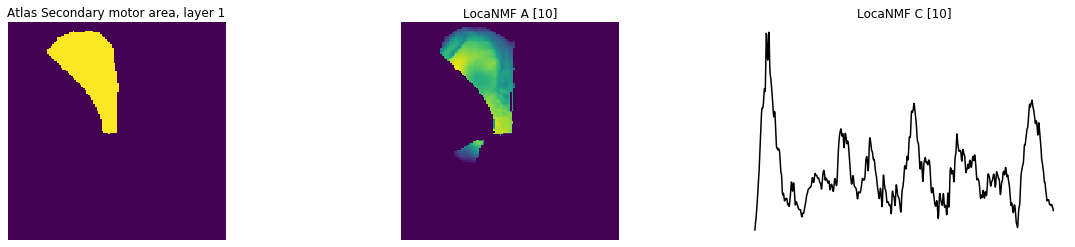

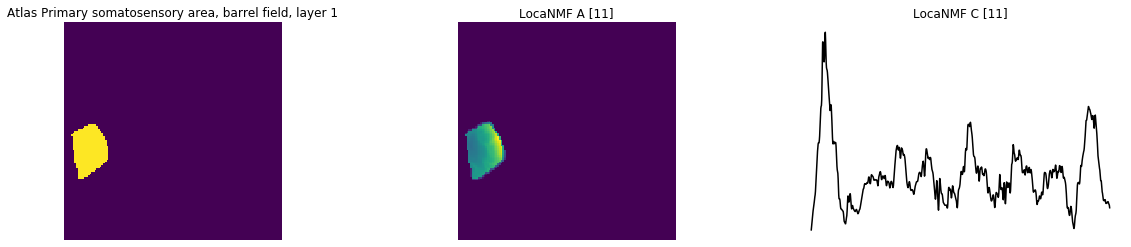

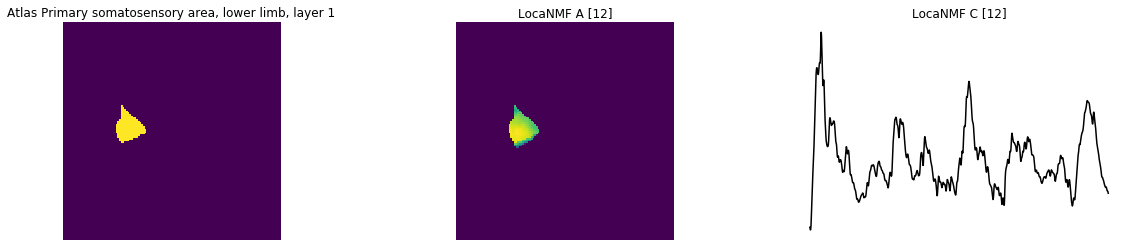

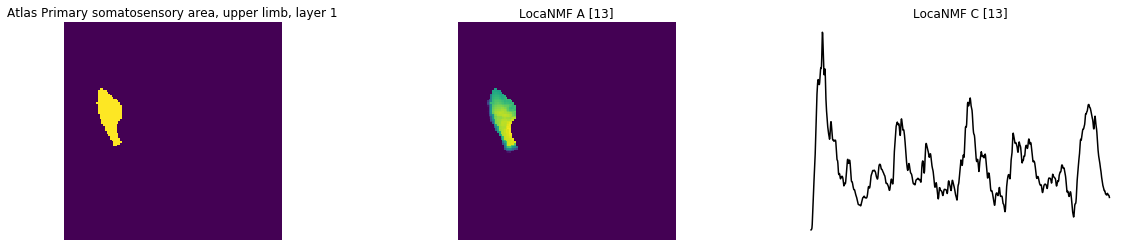

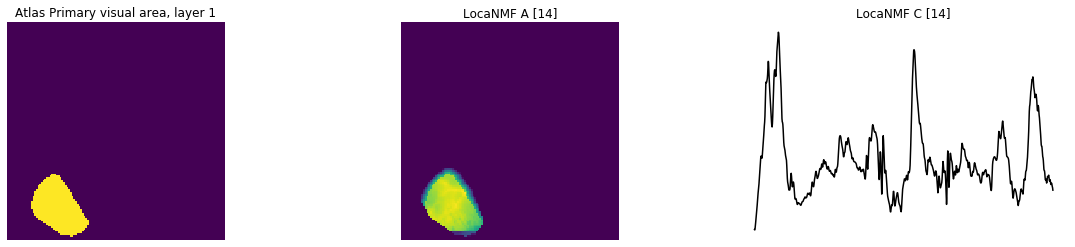

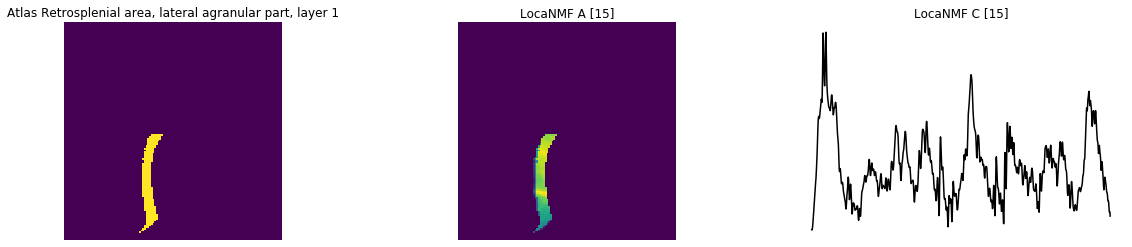

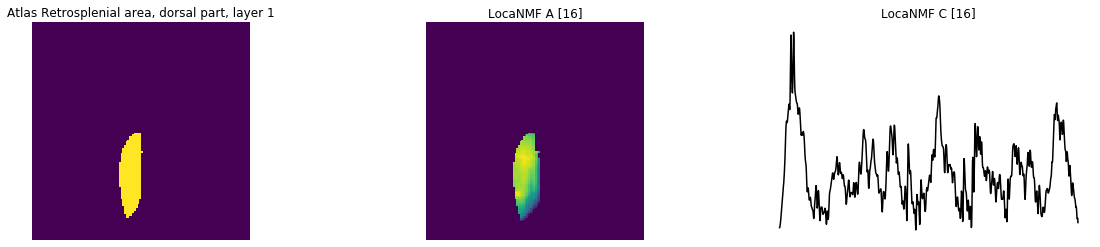

In [55]:
# Plotting all the regions' components
for i,area in enumerate(areas):
    try:
        fig=plt.figure(figsize=(20,4))
        ax1 = fig.add_subplot(1,3,1)
        plotmap_area = np.zeros((atlas.shape));
        plotmap_area.fill(np.nan);
        plotmap_area[brainmask] = atlas[brainmask]==area
        ax1.imshow(plotmap_area);
        ax1.set_title('Atlas '+areanames_area[i])
        ax1.axis('off')

        ax2 = fig.add_subplot(1,3,2)
        ax2.imshow(A_reshape[:,:,i])
        ax2.set_title('LocaNMF A [%s]'%(i+1))
        ax2.axis('off')

        ax3 = fig.add_subplot(1,3,3)
        ax3.plot(C[i,:min(1000,C.shape[1])],'k')
        if simulation:
            ax3.plot(V[np.where(area==trueareas)[0][0],:min(1000,V.shape[1])],'r');
            if i==0: ax3.legend(('LocaNMF','True'))
        ax3.set_title('LocaNMF C [%s]'%(i+1))
        ax3.axis('off')
        plt.show()
    except:
        pass


In [56]:
# Calculate Canonical Correlations between components in each pair of regions
corrmat=np.zeros((len(areainds),len(areainds)))
skipinds=[]
for i,area_i in enumerate(areainds):
    for j,area_j in enumerate(areainds):
        if i==0 and area_j not in areas:
            skipinds.append(j)
        C_i=C[np.where(areas==area_i)[0],:].T
        C_j=C[np.where(areas==area_j)[0],:].T
        if i not in skipinds and j not in skipinds:
            cca=CCA(n_components=1)
            cca.fit(C_i,C_j)
            C_i_cca,C_j_cca=cca.transform(C_i,C_j)
            try: C_i_cca=C_i_cca[:,0]
            except: pass
            try: C_j_cca=C_j_cca[:,0]
            except: pass               
            corrmat[i,j]=np.corrcoef(C_i_cca,C_j_cca)[0,1]
corrmat=np.delete(corrmat,skipinds,axis=0); 
corrmat=np.delete(corrmat,skipinds,axis=1);
corr_areanames=np.delete(areanames_all,skipinds)

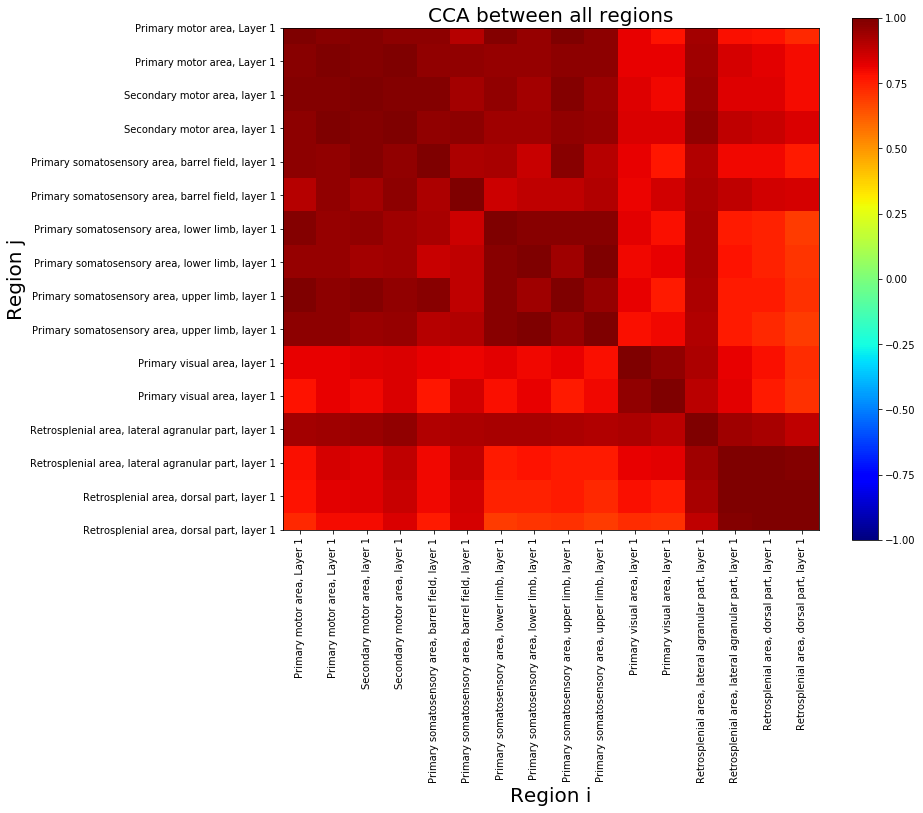

In [57]:
# Plot correlations
fig=plt.figure(figsize=(12,12))
plt.imshow(corrmat,cmap=plt.cm.get_cmap('jet')); plt.clim(-1,1); plt.colorbar(shrink=0.8)
plt.get_cmap('jet')
plt.xticks(ticks=np.arange(len(areainds)-len(skipinds)),labels=corr_areanames,rotation=90); 
plt.yticks(ticks=np.arange(len(areainds)-len(skipinds)),labels=corr_areanames); 
plt.title('CCA between all regions',fontsize=20)
plt.xlabel('Region i',fontsize=20)
plt.ylabel('Region j',fontsize=20)
plt.show()

In [58]:
# lambda and percentage
data=np.array([locanmf_comps.lambdas.data.numpy(),per.numpy()])
data

array([[147.78918 , 332.52567 , 147.78918 , 332.52567 , 332.52567 ,
        332.52567 ,  65.68408 ,  65.68408 ,  65.68408 ,  29.192926,
        332.52567 , 332.52567 , 332.52567 , 147.78918 , 332.52567 ,
        147.78918 ],
       [ 91.30493 ,  93.93449 ,  95.37436 ,  96.85986 ,  95.14047 ,
         97.337814,  98.49879 ,  90.338066,  94.19221 ,  90.564476,
         94.49453 ,  93.4863  ,  90.493904,  93.292145,  95.00573 ,
         92.809395]], dtype=float32)

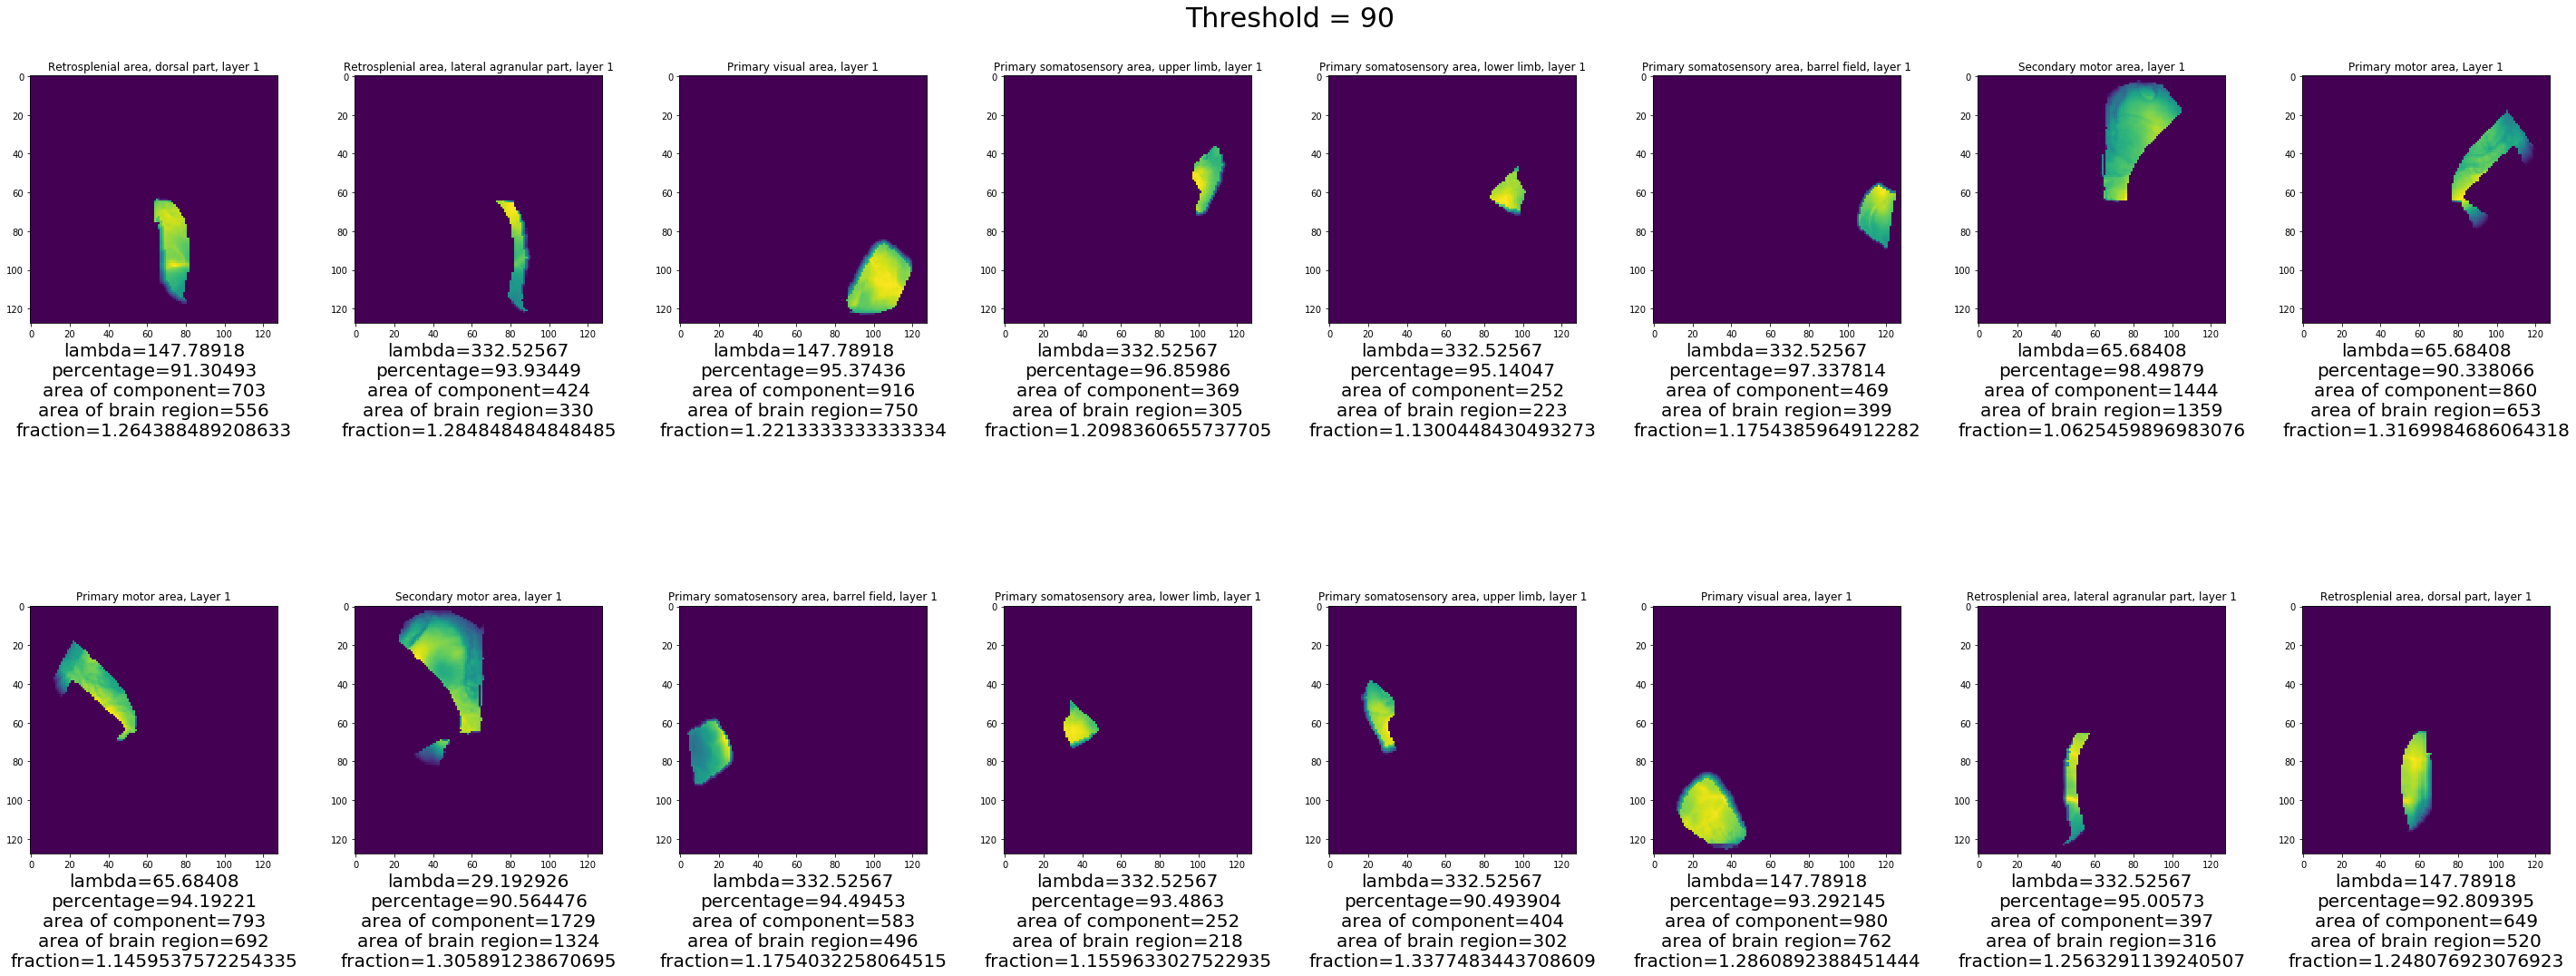

In [59]:
fig=plt.figure(figsize=(40,40))
checking_index=[]
checking_area=[]
unreached_index=[]
for i in range(A_reshape.shape[2]):
    plt.subplot(5,8,i+1)
    plt.imshow(A_reshape[:,:,i])
    sq_spatial=np.sum(A_reshape[:,:,i]!=0)
    sq_atlas=square_atlas[i]
    fra=sq_spatial/sq_atlas
    if fra>1.5 or fra<0.66:
        checking_index.append(i)
        checking_area.append(sq_spatial)
    if data[1,i]<loc_thresh:
        unreached_index.append(i)
    plt.title(areanames_area[i],fontsize=12)
    plt.xlabel('lambda='+str(data[0,i])+'\npercentage='+str(data[1,i])+'\narea of component='+str(sq_spatial)+'\narea of brain region='+str(sq_atlas)+'\nfraction='+str(fra),fontsize=20)
plt.tight_layout(h_pad=0.5,w_pad=0.5)
fig.suptitle('Threshold = '+str(loc_thresh),fontsize=30)
# plt.savefig(str(loc_thresh)+'.png',bbox_inches='tight')
plt.show()

# Checking

In [60]:
if r2_fit<0.9:
    print('r2 is not fine! r2 = '+str(r2_fit))
if len(checking_index)==0 and len(unreached_index)==0:
    print('Well components!')
if len(checking_index)>0:
    print('The following components are unreasonable because of the ratio of the area of component and the area of its corresponding brain region : ')
    print(checking_index)
    print('The area of component: '+str(checking_area))
if len(unreached_index)>0:
    print('The following components did not reach the threshold: ')
    print(unreached_index)

Well components!


In [61]:
print(save_lam.shape)
print(save_spa.shape)

(14, 16)
(14, 16, 16384)


In [62]:
visual_index=13 # choose component that needs visualization

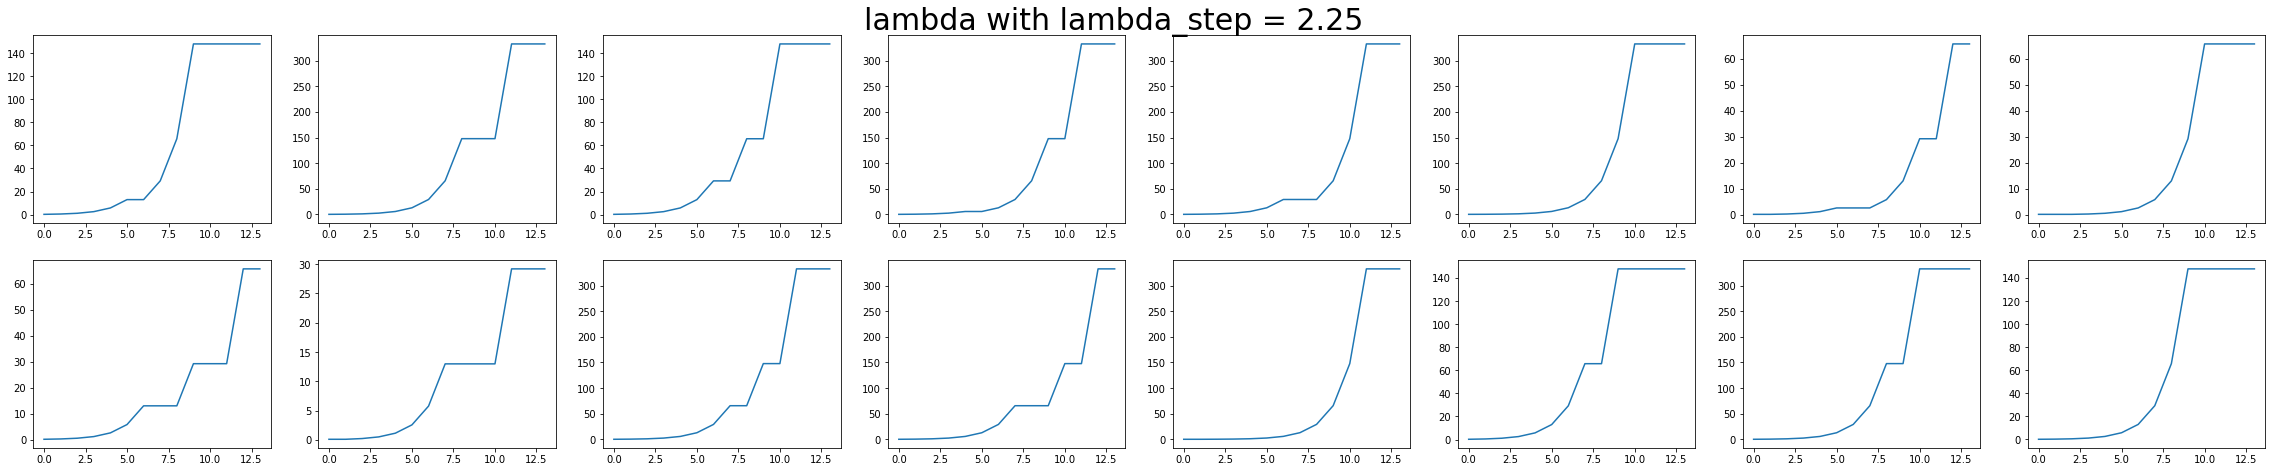

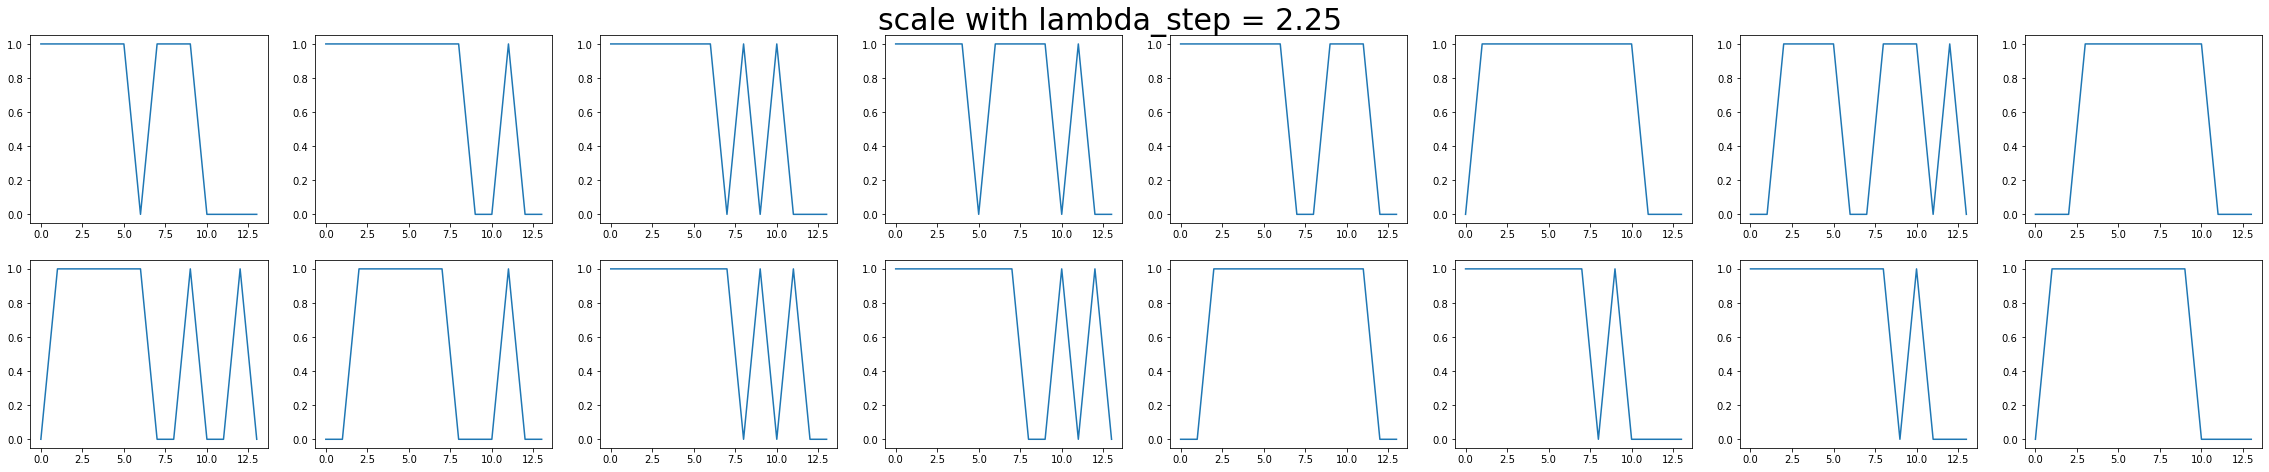

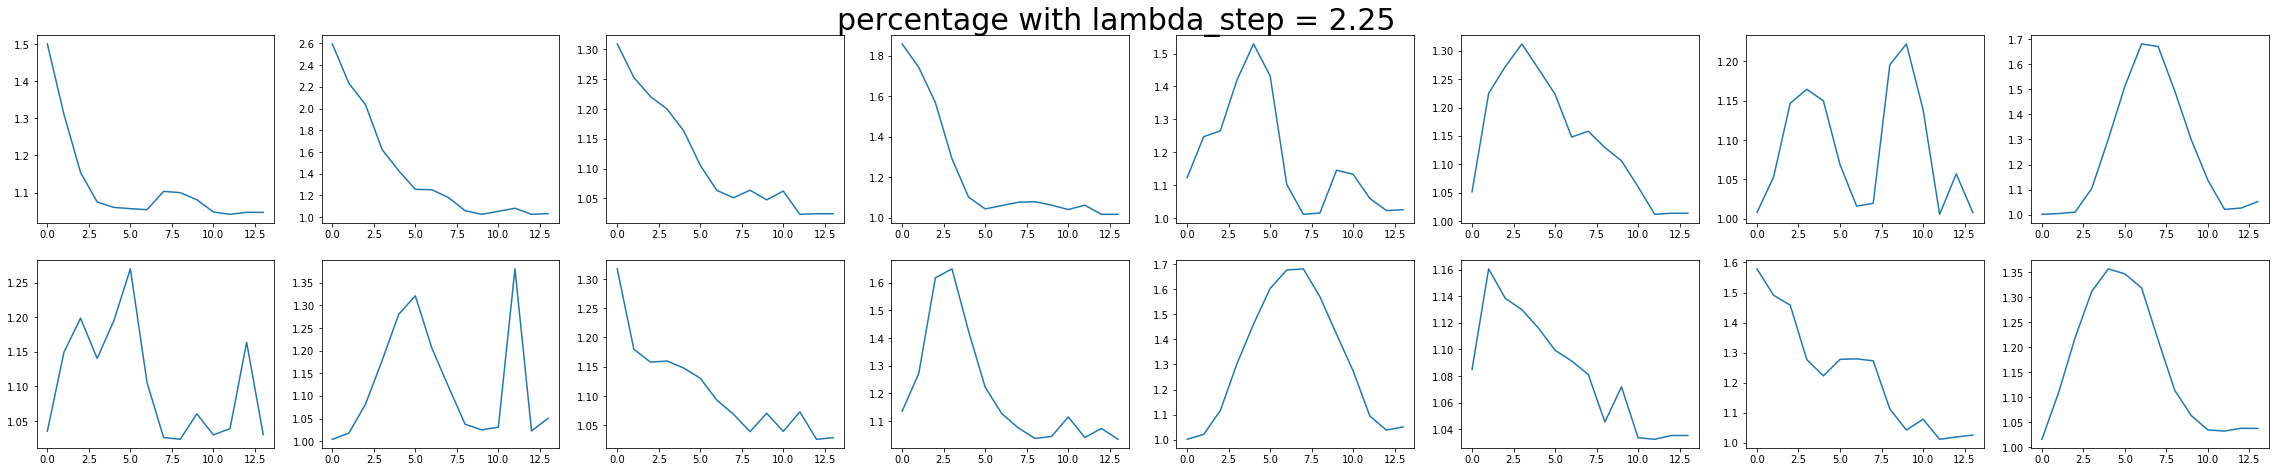

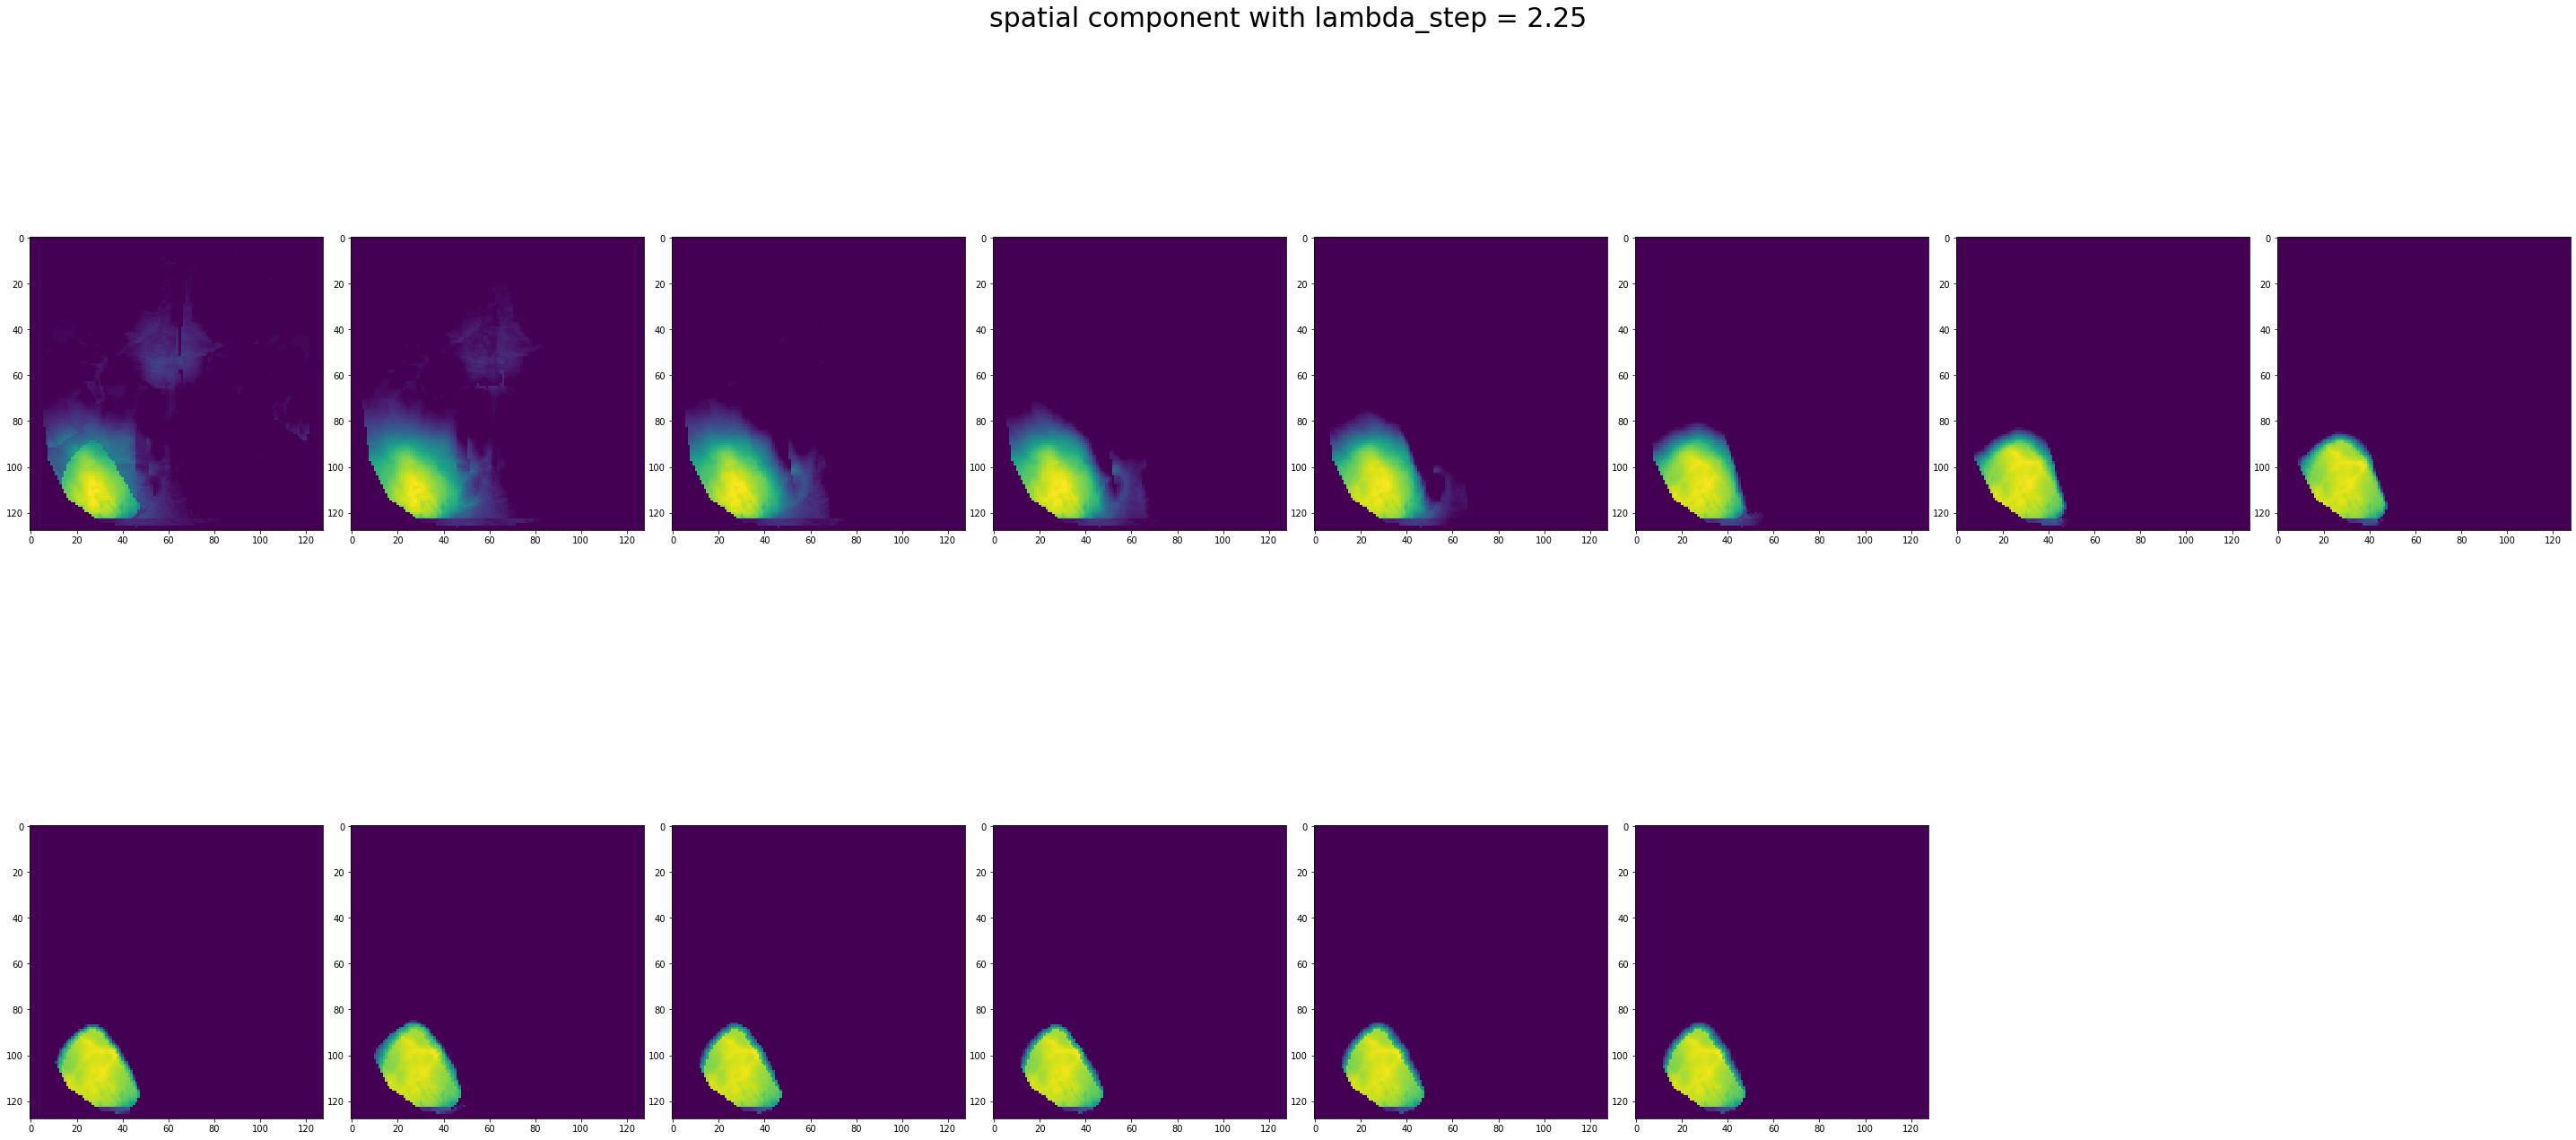

In [63]:
if save_lam.ndim!=2:
    print('May not be able to visualize, because some components are removed, need to check the above figure of components!')
if save_lam.ndim==2:
    fig=plt.figure(figsize=(40,20))
    for i in range(save_lam.shape[1]):
        plt.subplot(5,8,i+1)
        plt.plot(save_lam[:,i])
    fig.suptitle('lambda with lambda_step = '+str(lambda_step),fontsize=30,y=0.9)
    plt.show()
    fig=plt.figure(figsize=(40,20))
    for i in range(save_scale.shape[1]):
        plt.subplot(5,8,i+1)
        plt.plot(save_scale[:,i])
    fig.suptitle('scale with lambda_step = '+str(lambda_step),fontsize=30,y=0.9) # if reached the threshold or not.
    plt.show()
    fig=plt.figure(figsize=(40,20))
    for i in range(save_per.shape[1]):
        plt.subplot(5,8,i+1)
        plt.plot(save_per[:,i])
    fig.suptitle('percentage with lambda_step = '+str(lambda_step),fontsize=30,y=0.9)
    plt.show()
    fig=plt.figure(figsize=(40,20))
    for i in range(save_spa.shape[0]):
        plt.subplot(int(save_spa.shape[0]/8)+1,8,i+1)
        plt.imshow(save_spa[i,visual_index,:].reshape(128,128))
    fig.suptitle('spatial component with lambda_step = '+str(lambda_step),fontsize=30,y=1.02)
    plt.tight_layout(h_pad=0.5,w_pad=0.5)
    plt.show()